# Question 4 - Visualisations simples #

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
sys.path.append(os.path.abspath("../"))
from features.Pbp_DataFrame import Pbp_to_DataFrame
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as mpatches

In [55]:
"""
Cette fonction prend en entrée une saison au choix (ex. '2023-2024') et
retourne un DataFrame contenant toutes les informations de chaque événement
de tous les matchs de cette saison.
"""
def get_season_df(season):
    data_path = '../../games_data'                      # Path vers les données
    season_folder = os.path.join(data_path, season)     # Path des données de la saison
    
    games_dfs = []
    
    # Transformer en DataFrame les événements de chaque match et
    # sauvegarder chaque DataFrame dans une liste
    for game in os.listdir(season_folder):
        game_id = os.path.splitext(game)[0]
        game_df = Pbp_to_DataFrame().build_game_DataFrame(game_id) 
        # Ne pas prendre en compte les matchs sans événements (données manquantes)
        if game_df.empty:
            print(f"Empty DataFrame for game {game_id}")
        else:
            games_dfs.append(game_df)
        
    # Concaténer les DataFrames de chaque match pour former le DataFrame de la saison
    season_df = pd.concat(games_dfs, ignore_index=True)
    
    return season_df
    

## 1. Graphique comparant les types de tirs de toutes les équipes dans la saison 2023-2024 ##

In [56]:
"""
Cette fonction prend en argument un DataFrame de saison et retourne un DataFrame
indiquant le nombre de tirs pour chaque type de tir.
"""
def get_shots_frequency_by_type(df):

    # Compter le nombre de tirs et buts (colonnes) pour chaque type (lignes)
    type_frequency_df = pd.crosstab(df['Type of Shot'], df['Event Type'])

    # Supprimer la ligne "Unknown" (tirs pour lesquels son type était manquant)
    type_frequency_df = type_frequency_df.drop(index="Unknown", errors="ignore")

    return type_frequency_df
    

In [57]:
"""
Fonction pour annoter les barres dans un histogramme.
"""
def add_bar_labels(bars, type, precision=1):
    for bar in bars:
        for patch in bar.patches:
            height = patch.get_height()
            if type == 'int':
                if height > 0:      # Ne rien annoter pour les bares d'hauteur 0
                    plt.text(
                        patch.get_x() + patch.get_width() / 2,  # Centrer horizontalement sur la bare
                        height,
                        f"{int(height)}",   # Texte annoté
                        ha='center', va='bottom', fontsize=8
                    )
            if type == 'float':
                if height > 0:
                    plt.text(
                        patch.get_x() + patch.get_width() / 2,
                        height,
                        f"{round(height, precision)}",  # Texte annoté
                        ha='center', va='bottom', fontsize=8
                    )

In [58]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Obtention des données
df = get_season_df('2023-2024')                      # Données de la saison
type_frequency_df = get_shots_frequency_by_type(df)  # Fréquences pour chaque type de tir

# Trier pour une meilleure visualisation 
# (par nombre de tirs, ordre décroissant)
type_frequency_df = type_frequency_df.sort_values(by='Shot', ascending=False)

# Extraire données triées
shot_types = type_frequency_df.index.tolist()
shots_count = type_frequency_df['Shot'].tolist()
goals_count = type_frequency_df['Goal'].tolist()

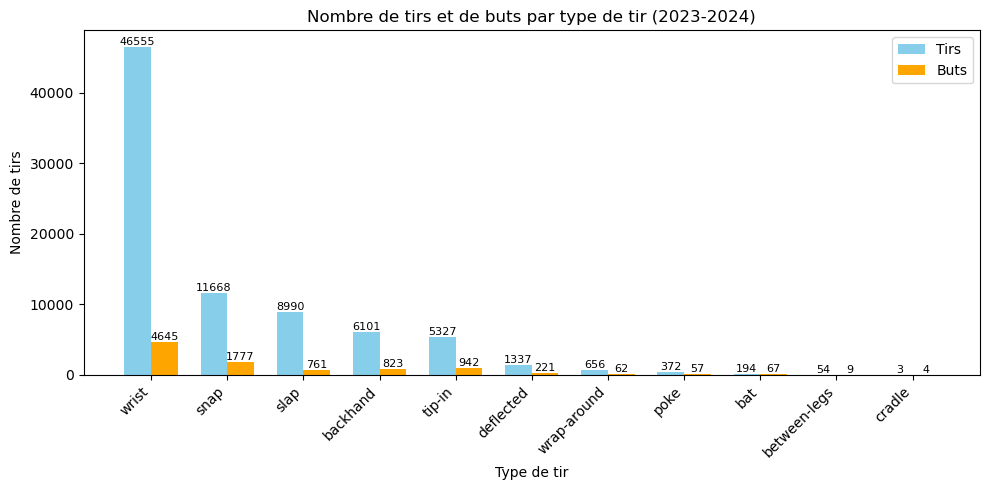

In [59]:
"""-------- GRAPHIQUE: Histogramme (barres côte à côte) --------"""

x = np.arange(len(shot_types))  # Positions des barres
width = 0.35    # Largeur des barres

plt.figure(figsize=(10,5))

# Afficher les barres 
shots_bars = plt.bar(x - width/2, shots_count, width, label='Tirs', color='skyblue')
goals_bars = plt.bar(x + width/2, goals_count, width, label='Buts', color='orange')
add_bar_labels([shots_bars, goals_bars], 'int')  # Annoter les barres avec sa valeur

# Titre et étiquettes
plt.ylabel('Nombre de tirs')
plt.xlabel('Type de tir')
plt.title('Nombre de tirs et de buts par type de tir (2023-2024)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


In [60]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Calculer le nombre total de tirs (buts ou pas) pour chaque type
type_frequency_df['Total'] = type_frequency_df['Shot'] + type_frequency_df['Goal']

# Calculer la proportion des buts (#buts/#total de tirs) pour chaque type
type_frequency_df['Proportion'] = type_frequency_df['Goal'] / type_frequency_df['Total']

# Trier les valeur pour une meilleure visualisation (par proportion, ordre décroissant)
type_frequency_df = type_frequency_df.sort_values(by='Proportion', ascending=False)
shot_types = type_frequency_df.index.tolist()

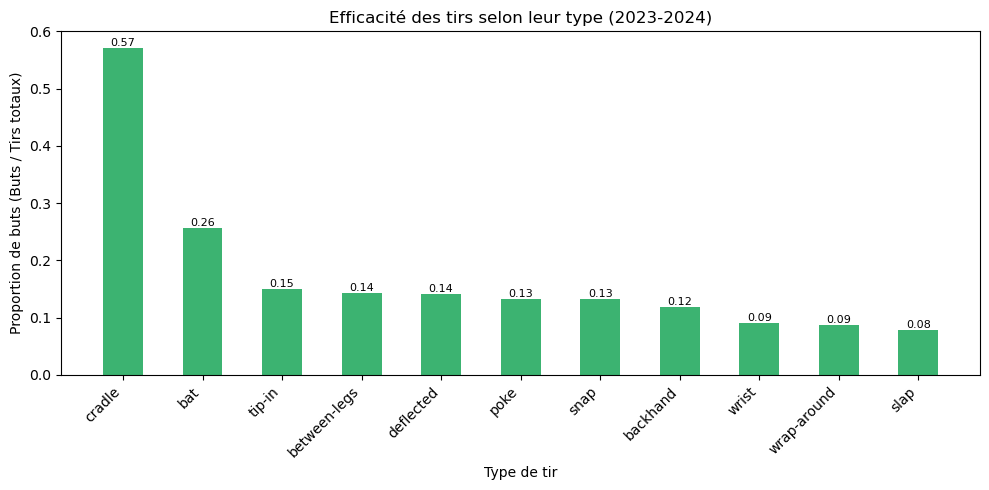

In [61]:
"""-------- GRAPHIQUE: Histogramme (proportion de #buts/#total de tirs) --------"""

plt.figure(figsize=(10,5))

# Positions des barres
x = np.arange(len(shot_types)) 

# Afficher les barres
proportion_bars = plt.bar(x, type_frequency_df['Proportion'], width= 0.5, color='mediumseagreen')
add_bar_labels([proportion_bars], 'float', 2)

# Titre et étiquettes
plt.title('Efficacité des tirs selon leur type (2023-2024)')
plt.ylabel('Proportion de buts (Buts / Tirs totaux)')
plt.xlabel('Type de tir')
plt.xticks(x, shot_types, rotation=45, ha='right')

plt.tight_layout()
plt.show()



### (b) Trouver la distance des tirs ###

In [62]:
"""
Cette fonction prend en entrée un DataFrame d'événements et modifie la zone
des tirs effectués dans la zone neutre (N) pour indiquer s'il a été effectué
dans la partie offensive (NO) ou défensive (ND) de la zone neutre.

Ceci nous aidera à identifier correctement de quel côté du terrain et 
vers quelle direction chaque tir à été effectué.
"""
def divide_N_zone(df):
    for idx, row in df.iterrows():
        if row['Zone'] == 'N':
            if row['Team'] == row['Home Team']:   # Same team as home
                if row['Home Team D Side'] == 'left':
                    df.at[idx, 'Zone'] = 'ND' if row['X'] < 0 else 'NO'
                else:  # right
                    df.at[idx, 'Zone'] = 'NO' if row['X'] < 0 else 'ND'
            else:  # Away team
                if row['Home Team D Side'] == 'left':
                    df.at[idx, 'Zone'] = 'NO' if row['X'] < 0 else 'ND'
                else:  # right
                    df.at[idx, 'Zone'] = 'ND' if row['X'] < 0 else 'NO'
    return df



In [63]:
"""
Cette fonction prend en argument un tir (événement) et calcule sa distance par rapport à la cage.
Ici on prend en compte la cage vers laquelle le tir à été effectué (direction du tir).
Les distances sont calculées en supposant que la trajectoire est une ligne droite vers la cage.
"""
def get_shot_distance(event):

    # Coordonnées des cages
    left_goal = (-89, 0)
    right_goal = (89, 0)
    
    # Coordonnées du tir
    x_coord = event['X']
    y_coord = event['Y']

    # Zone depuis laquelle le tir a été effectué
    zone = event['Zone']
    
    # On ignore les tirs qui ont des coordonnées manquantes
    if pd.isna(x_coord) or pd.isna(y_coord):
        return None
    
    # Calculer la distance entre la position du tir et les deux cages (Pythagore)
    dist_left = np.sqrt((x_coord - left_goal[0])**2 + (y_coord - left_goal[1])**2)
    dist_right = np.sqrt((x_coord - right_goal[0])**2 + (y_coord - right_goal[1])**2)

    # Choisir quelle distance est la correcte
    if zone == 'O' or zone == 'NO':
        shot_distance = min(dist_left, dist_right)
    elif zone == 'D' or zone == 'ND':
        shot_distance = max(dist_left, dist_right)
    else:   # zone = None (donnée manquante)
        shot_distance = min(dist_left, dist_right)
    
    return shot_distance.round(1)

In [64]:
"""
Cette fonction prend en argument une saison et retourne un DataFrame indiquant pour chaque événement:
- Type de l'événement (but ou tir)
- Type de tir
- Distance
"""
def get_shots_distances(season):
    df = get_season_df(season)  # Récupérer les données
    df = divide_N_zone(df)      # Formatter la zone des événements en zone neutre

    df['Distance'] = df.apply(get_shot_distance, axis=1)    # Calculer la distance
    df = df[['Event Type', 'Type of Shot', 'Distance']]     # Garder uniquement les informations utiles
    df = df[df['Type of Shot'] != "Unknown"]    # Éliminer les tirs avec type inconnu (type de tir manquant)
    df = df.dropna(subset=['Distance'])         # Éliminer les tirs sans distance (coordonnées manquantes)
    
    # Retourner aussi une version où les distances ont été arrondies à l'entier le plus proche
    rounded_df = df.copy()
    rounded_df['Distance'] = rounded_df['Distance'].round().astype(int)
    
    return df, rounded_df

### (a) Relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but ###

#### Saison 2018-2019 ####

In [65]:
df, rounded_df = get_shots_distances('2018-2019')

Empty DataFrame for game 2018010110
Empty DataFrame for game 2018010109


/var/folders/ht/5dt3l6tj3l77w68350y2_c080000gn/T/ipykernel_74732/1198676191.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


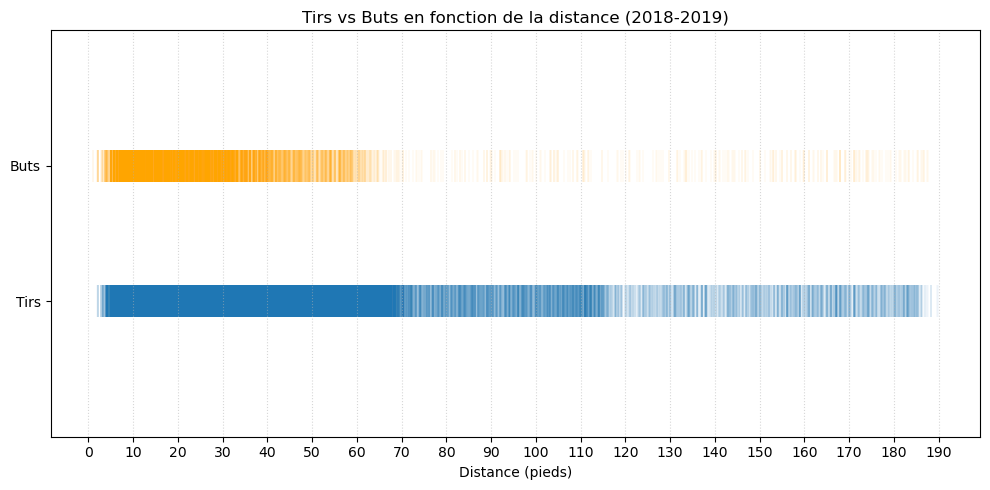

In [66]:
"""-------- GRAPHIQUE: Visualisation 1D du nombre de tirs/buts par rapport à la distance. --------"""

def plot1D(df, season):
    
    # Données
    shots_distance = df[df['Event Type'] == 'Shot']['Distance'].tolist()
    goals_distance = df[df['Event Type'] == 'Goal']['Distance'].tolist()

    plt.figure(figsize=(10,5))

    # Barre des Tirs
    plt.scatter(shots_distance, [0.1] * len(shots_distance),
                alpha=0.04, label="Tirs", s=500, marker="|")

    # Barre des Buts
    plt.scatter(goals_distance, [0.2] * len(goals_distance),
                alpha=0.04, label="Buts", s=500, color="orange", marker="|")

    # Titre et étiquettes
    plt.title(f"Tirs vs Buts en fonction de la distance ({season})")
    plt.ylim(0, 0.3)
    plt.yticks([0.1, 0.2], ["Tirs", "Buts"])
    plt.xlabel("Distance (pieds)")
    plt.grid(axis="x", linestyle=":", alpha=0.5)
    max_distance = max(max(shots_distance), max(goals_distance))
    plt.xticks(np.arange(0, max_distance + 10, 10), rotation=0)
    
    plt.tight_layout()
    plt.show()
    
plot1D(df, '2018-2019')

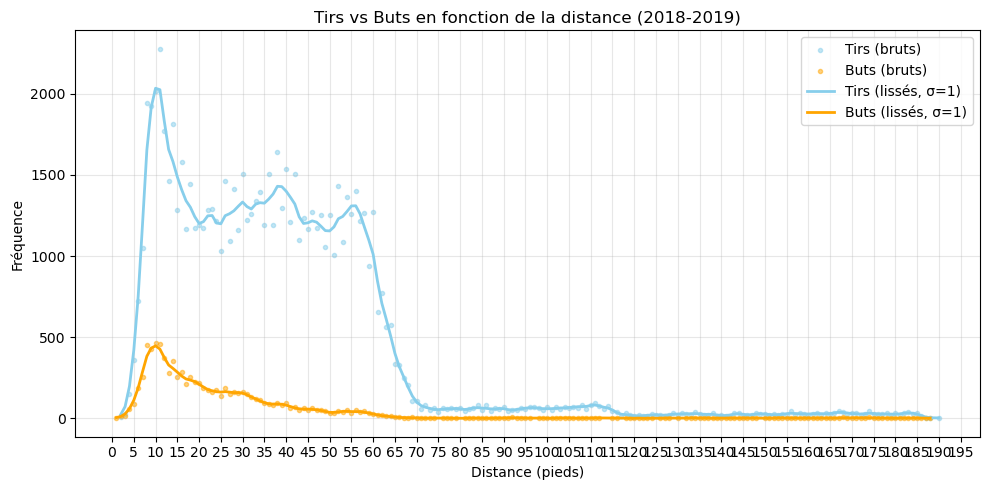

In [67]:
"""-------- GRAPHIQUE: Courbe de la fréquence d'appartition de chaque distance. --------"""

def smoothCurvePlot(df, season):
    
    # --- DONNÉES ---
    
    # Nombre de tirs manqués par distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    # Nombre de buts par distance
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    # Distances de tir (x = distance unique, y = fréquence des tirs à cette distance)
    shots_x = np.array(shots_distance_frequency.index)
    shots_y = np.array(shots_distance_frequency.values)

    # Distances des buts (x = distance unique, y = fréquence des buts à cette distance)
    goals_x = np.array(goals_distance_frequency.index)
    goals_y = np.array(goals_distance_frequency.values)
    
    
    
    # --- GRAPHIQUE ---

    plt.figure(figsize=(10, 5))

    # Lisser les fréquences avec un filtre gaussien pour atténuer les fluctuations brusques
    shots_y_smooth = gaussian_filter1d(shots_y, sigma=1)
    goals_y_smooth = gaussian_filter1d(goals_y, sigma=1)
    
    # Données brutes (points)
    plt.scatter(shots_x, shots_y, color="skyblue", alpha=0.5, marker=".", label="Tirs (bruts)")
    plt.scatter(goals_x, goals_y, color="orange", alpha=0.5, marker=".", label="Buts (bruts)")

    # Courbes lissées pour visualiser la tendance générale
    plt.plot(shots_x, shots_y_smooth, color="skyblue", label="Tirs (lissés, σ=1)", linewidth=2)
    plt.plot(goals_x, goals_y_smooth, color="orange", label="Buts (lissés, σ=1)", linewidth=2)

    # Titre et étiquettes
    plt.title(f'Tirs vs Buts en fonction de la distance ({season})')
    plt.xticks(np.arange(0, max(max(shots_x), max(goals_x)) + 10, 5))
    plt.xlabel('Distance (pieds)')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
smoothCurvePlot(rounded_df, '2018-2019')


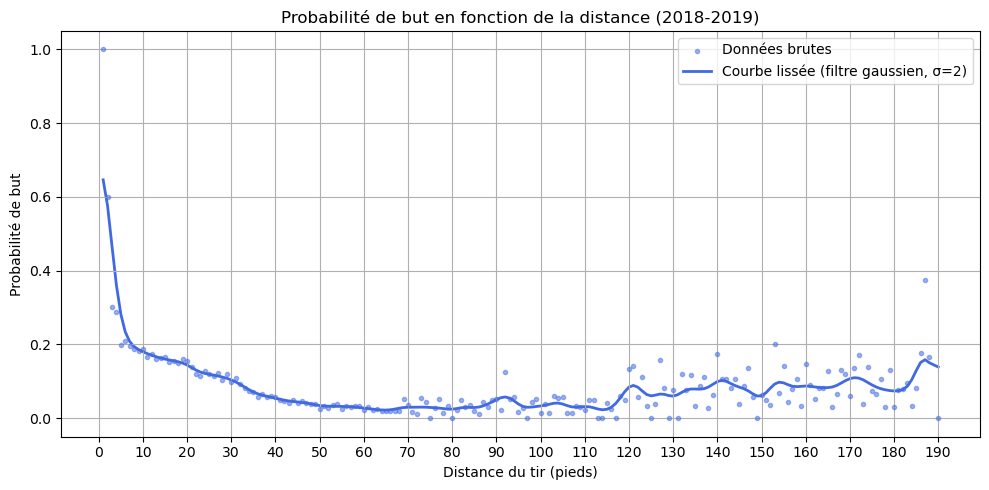

In [68]:
"""-------- GRAPHIQUE: Probabilité qu'un tir soit un but en fonction de la distance. --------"""
def goalChancePlot(df, season):
    
    # --- DONNÉES ---
    
    # Nombre de tirs manqués par distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    # Nombre de buts par distance
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    # Nombre total de tirs par distance (tirs + buts)
    total_shots_distance_frequency = shots_distance_frequency.add(goals_distance_frequency, fill_value=0)

    # Probabilité qu'un tir à une distance donnée devienne un but (#buts/#total de tirs --> à chaque distance)
    goal_chance_by_distance = goals_distance_frequency.divide(total_shots_distance_frequency, fill_value=0)


    # Lisser les probabilités avec un filtre gaussien pour atténuer les fluctuations brusques
    chance_smooth = gaussian_filter1d(goal_chance_by_distance.values, sigma=2)
    
    
    
    # --- GRAPHIQUE ---

    plt.figure(figsize=(10, 5))

    # Données brutes (points)
    plt.scatter(
        goal_chance_by_distance.index, 
        goal_chance_by_distance.values, 
        color='royalblue', 
        label='Données brutes', 
        zorder=2,
        marker=".",
        alpha=0.5
    )

    # Courbe lissée
    plt.plot(
        goal_chance_by_distance.index, 
        chance_smooth, 
        color='royalblue', 
        label='Courbe lissée (filtre gaussien, σ=2)', 
        linewidth=2, 
        zorder=1,
        alpha=1
    )

    # Titre et étiquettes
    plt.xticks(np.arange(0, max(goal_chance_by_distance.index) + 10, 10))
    plt.title(f'Probabilité de but en fonction de la distance ({season})')
    plt.xlabel('Distance du tir (pieds)')
    plt.ylabel('Probabilité de but')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


goalChancePlot(rounded_df, '2018-2019')

#### Saison 2019-2020 ####

Empty DataFrame for game 2019010106
Empty DataFrame for game 2019010107


/var/folders/ht/5dt3l6tj3l77w68350y2_c080000gn/T/ipykernel_74732/1198676191.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


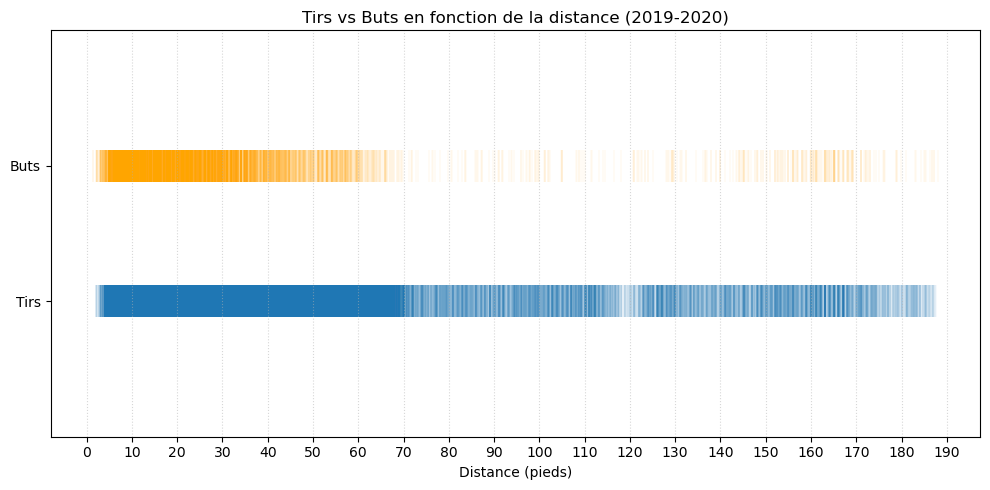

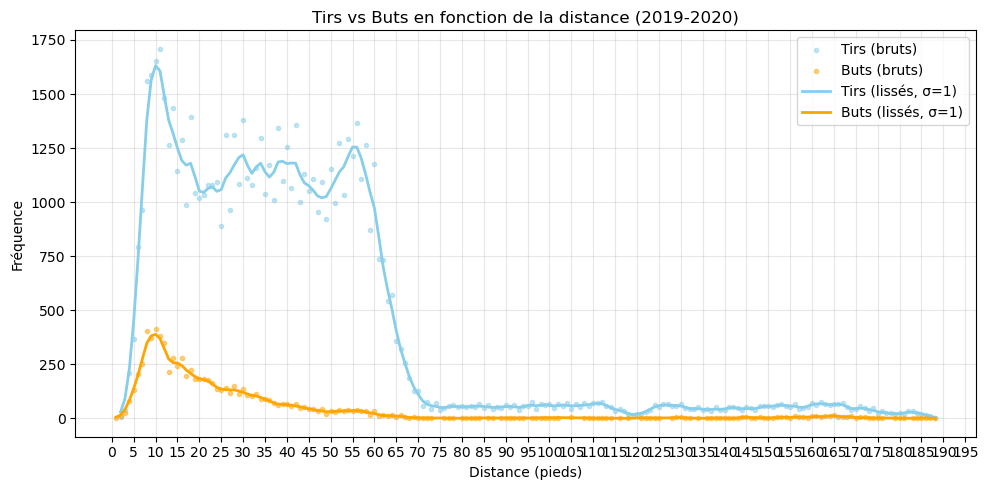

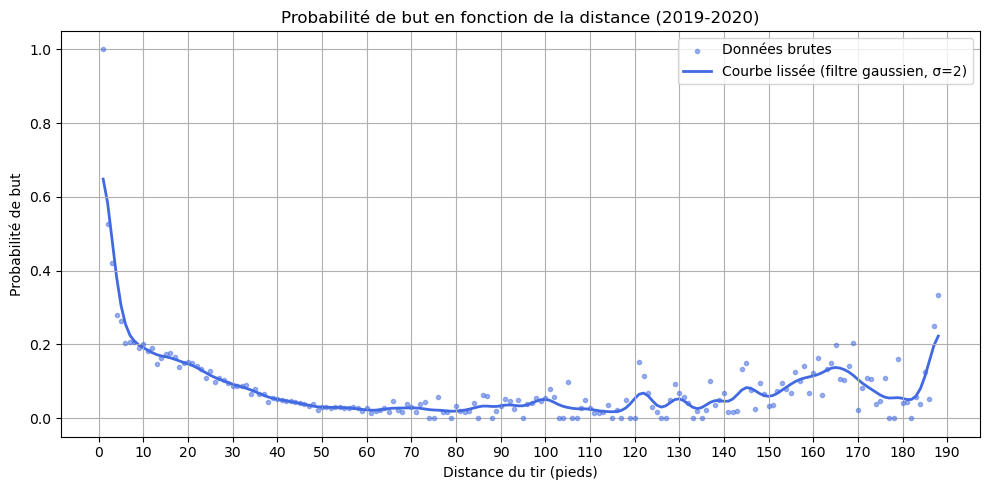

In [69]:
df, rounded_df = get_shots_distances('2019-2020')

plot1D(df, '2019-2020')
smoothCurvePlot(rounded_df, '2019-2020')
goalChancePlot(rounded_df, '2019-2020')

#### Saison 2020-2021 ####

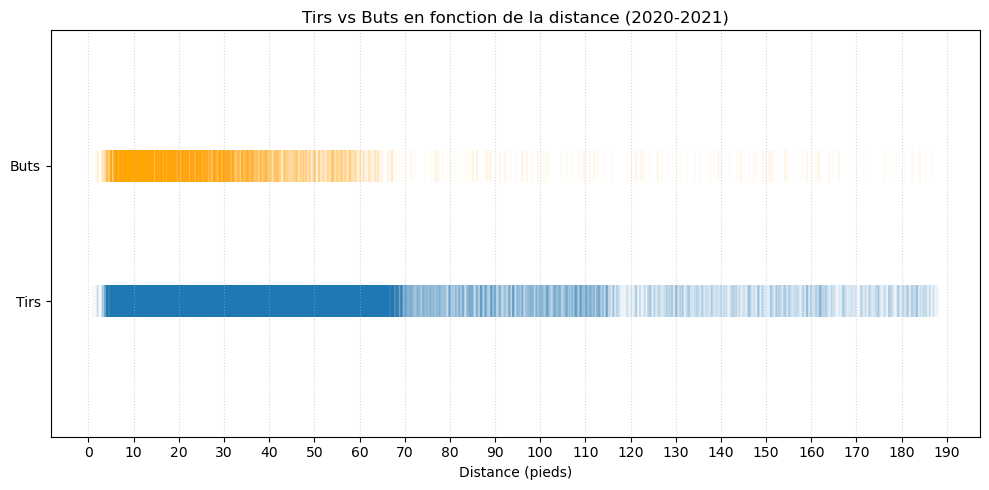

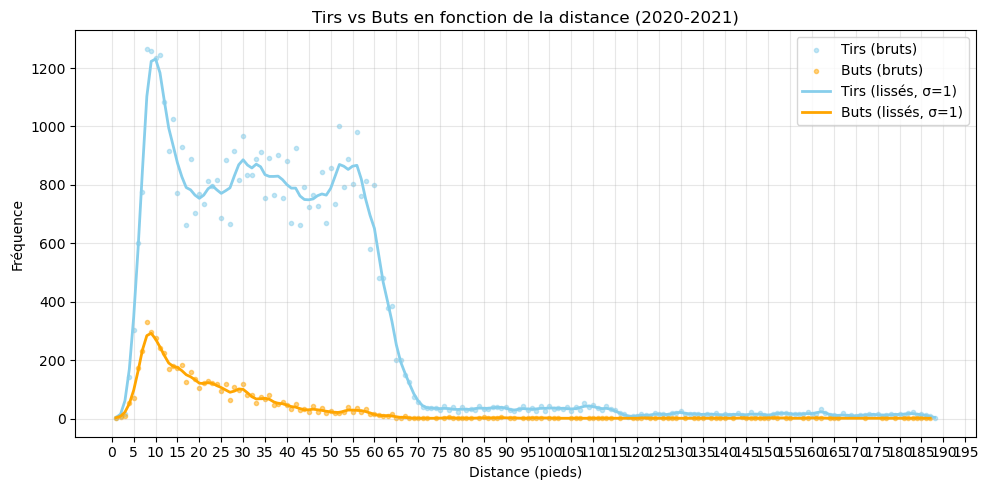

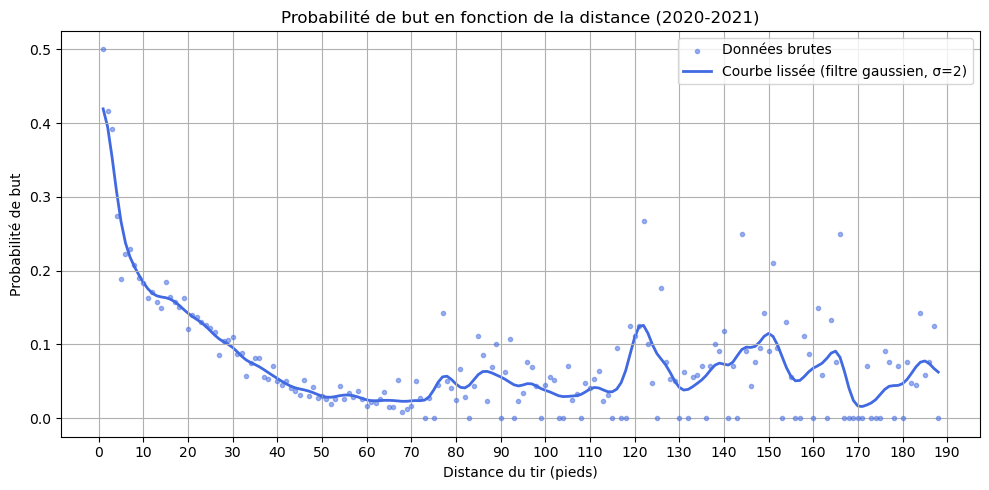

In [70]:
df, rounded_df = get_shots_distances('2020-2021')

plot1D(df, '2020-2021')
smoothCurvePlot(rounded_df, '2020-2021')
goalChancePlot(rounded_df, '2020-2021')

## 2. Pourcentage de buts en fonction de la distance et du type de tir pour la saison 2023-2024 ##

In [71]:
"""-------- TRAITEMENT DES DONNÉES --------"""

df, rounded_df = get_shots_distances('2023-2024')


# --- TIRS RATÉS ---
shots_distance = rounded_df[rounded_df['Event Type']=='Shot']
grouped_shots_data = shots_distance.groupby(['Type of Shot', 'Distance'])
# Nombre de tirs par type et par distance
shots_distance_frequency_by_type = grouped_shots_data.size().unstack(fill_value=0)

# --- BUTS ---
goals_distance = rounded_df[rounded_df['Event Type']=='Goal']
grouped_goals_data = goals_distance.groupby(['Type of Shot', 'Distance'])
# Nombre de buts par type et par distance
goals_distance_frequency_by_type = grouped_goals_data.size().unstack(fill_value=0)


# Nombre de total tirs par type et par distance
total_shots_distance_frequency_by_type = shots_distance_frequency_by_type.add(goals_distance_frequency_by_type, fill_value=0)

# Pourcentage de buts en fonction du type et de la distance
goal_percentage_by_distance_and_type = goals_distance_frequency_by_type.divide(total_shots_distance_frequency_by_type, fill_value=0)

# Inclure toutes les distances possibles (même celles où il n’y a pas de tirs)
distances = goal_percentage_by_distance_and_type.columns
full_distances = np.arange(distances.min(), distances.max() + 1)
goal_percentage_by_distance_and_type = goal_percentage_by_distance_and_type.reindex(columns=full_distances, fill_value=np.nan)

# Réorganiser les lignes pour favoriser la visualisation
order = [
    'cradle',
    'between-legs',
    'wrap-around',
    'bat',
    'poke',
    'deflected',
    'tip-in',
    'slap',
    'backhand',
    'snap',
    'wrist'
]
goal_percentage_by_distance_and_type = goal_percentage_by_distance_and_type.reindex(order)


# Extraire les distances (colonnes) et les types de tirs (lignes)
distances = goal_percentage_by_distance_and_type.columns
shot_types = goal_percentage_by_distance_and_type.index



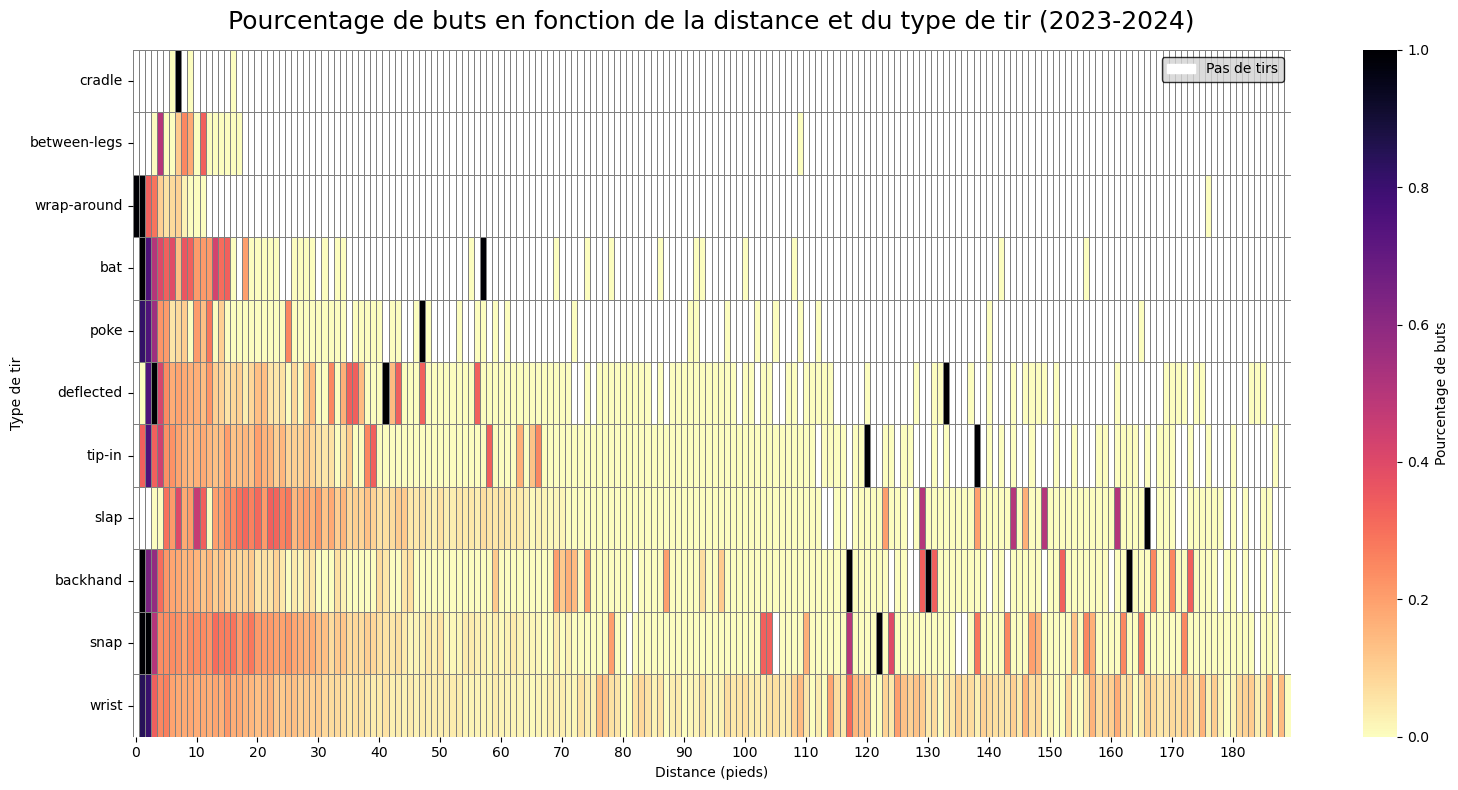

In [72]:
"""-------- GRAPHIQUE: Heatmap du pourcentage de buts en fonction de la distance et du type de tir. --------"""

plt.figure(figsize=(16, 8))

# -- Couleurs --
cmap = plt.colormaps.get_cmap("magma_r").copy()     # Couleur : YlOrRd - OrRd - YlOrBr - magma_r - inferno_r
mask = goal_percentage_by_distance_and_type.isna()  # Masque pour les cellules sans tirs (NaN)
cmap.set_bad(color='white')                         # Couleur pour les cellules sans tirs (NaN)


# -- Heatmap --
sns.heatmap(
    goal_percentage_by_distance_and_type,      # Données
    cmap=cmap,                                 # Couleurs
    mask = mask,                               # Masquer les NaN (affichés en blanc)
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Pourcentage de buts'}  # Légende de la barre de couleurs
)


# Titre et étiquettes
plt.title('Pourcentage de buts en fonction de la distance et du type de tir (2023-2024)', fontsize=18, pad=15)
plt.xlabel('Distance (pieds)')
xticks = np.arange(0, len(distances), 10)
xtick_labels = distances[xticks]
plt.xticks(ticks=xticks + 0.5, labels=xtick_labels, rotation=0)
plt.ylabel('Type de tir')

# Légende pour les cellules sans tirs
no_data_patch = mpatches.Patch(color='white', label='Pas de tirs')
plt.legend(handles=[no_data_patch],
           loc='upper right',
        #    bbox_to_anchor=(1.145, -0.04),
           frameon=True,
           facecolor='lightgray',
           edgecolor='black')

plt.tight_layout()
plt.show()

In [73]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Extraire les distances (colonnes) et les types de tirs (lignes)
distances = total_shots_distance_frequency_by_type.columns
shot_types = total_shots_distance_frequency_by_type.index

# Réorganiser les lignes pour favoriser la visualisation
order = [
    'cradle',
    'between-legs',
    'wrap-around',
    'bat',
    'poke',
    'deflected',
    'tip-in',
    'slap',
    'backhand',
    'snap',
    'wrist'
]
total_shots_distance_frequency_by_type = total_shots_distance_frequency_by_type.reindex(order)

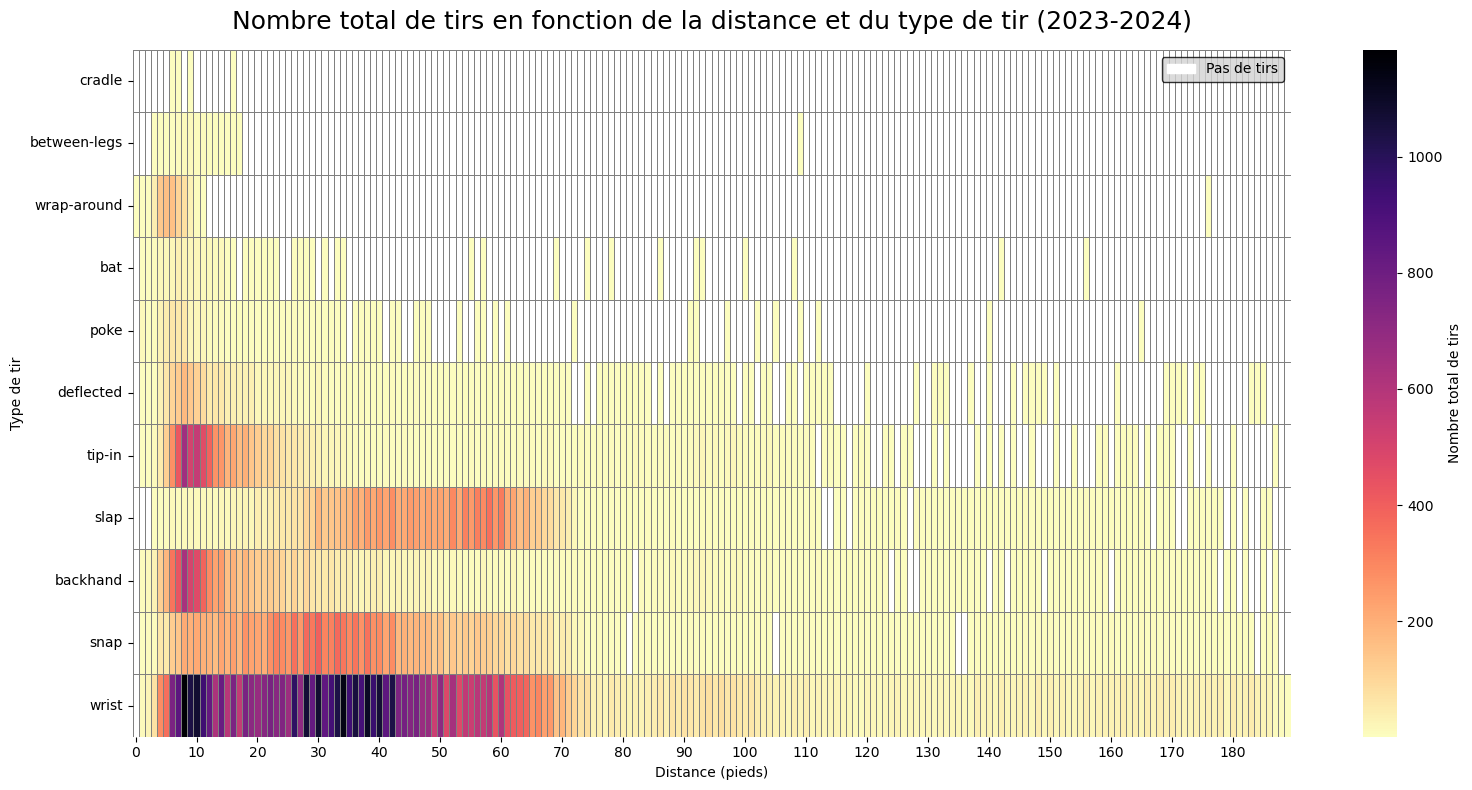

In [74]:
"""-------- GRAPHIQUE: Heatmap du nombre total de tirs en fonction de la distance et du type. --------"""

plt.figure(figsize=(16, 8))

# -- Couleurs --
cmap = plt.colormaps.get_cmap("magma_r").copy()     # Couleur : YlOrRd - OrRd - YlOrBr - magma_r - inferno_r
mask = total_shots_distance_frequency_by_type == 0  # Masque pour les cellules sans tirs (0)
cmap.set_bad(color='white')                         # Couleur pour les cellules sans tirs (0)

# -- Heatmap --
sns.heatmap(
    total_shots_distance_frequency_by_type,    # Données
    cmap=cmap,                                 # Couleurs
    mask=mask,                                 # Masquer les 0 (affichés en blanc)
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Nombre total de tirs'}  # Légende de la barre de couleurs
)


# Titre et étiquettes
plt.title('Nombre total de tirs en fonction de la distance et du type de tir (2023-2024)', fontsize=18, pad=15)
plt.xlabel('Distance (pieds)')
xticks = np.arange(0, len(distances), 10)
xtick_labels = distances[xticks]
plt.xticks(ticks=xticks + 0.5, labels=xtick_labels, rotation=0)
plt.ylabel('Type de tir')

# Légende pour les cellules sans tirs
no_data_patch = mpatches.Patch(color='white', label='Pas de tirs')
plt.legend(handles=[no_data_patch],
           loc='upper right',
        #    bbox_to_anchor=(1.145, -0.04),
           frameon=True,
           facecolor='lightgray',
           edgecolor='black')


plt.tight_layout()
plt.show()

In [75]:
goal_percentage_by_distance_and_type_noNaN = goal_percentage_by_distance_and_type.copy()
goal_percentage_by_distance_and_type_noNaN.fillna(0)

# TODO: Figure 3D intéractive

Distance,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
Type of Shot,,,,,,,,,,,,,,,,,,,,,
cradle,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
between-legs,0.0,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.111111,0.250000,0.181818,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
wrap-around,1.0,1.000000,0.333333,0.289474,0.101449,0.062112,0.076433,0.096154,0.025641,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
bat,0.0,1.000000,0.750000,0.500000,0.400000,0.333333,0.391304,0.135135,0.360000,0.333333,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
poke,0.0,0.818182,0.750000,0.555556,0.225806,0.209302,0.051724,0.075472,0.107143,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
deflected,0.0,0.000000,0.750000,1.000000,0.419355,0.245902,0.173077,0.193798,0.181818,0.166667,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
tip-in,0.0,0.333333,0.750000,0.333333,0.440000,0.233333,0.229091,0.191943,0.166667,0.151277,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
slap,0.0,0.000000,0.000000,0.000000,0.000000,0.300000,0.214286,0.400000,0.181818,0.214286,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
backhand,0.0,1.000000,0.642857,0.580645,0.305085,0.220339,0.190751,0.183908,0.152381,0.170974,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.0,0.000000,0.0
